In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize


In [5]:

#dataset_path = '/content/drive/MyDrive/dataAruba.csv'
data = pd.read_csv(dataset_path, delimiter=',', header=None, names=['Date', 'Time', 'Sensor ID', 'State', 'Activity Label', 'Start/End'])

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y', errors='coerce')
def preprocess_time_to_seconds(value):
    try:
        time_parts = value.split(':')
        minutes = int(time_parts[0])
        seconds = float(time_parts[1])
        total_seconds = minutes * 60 + seconds
        return total_seconds
    except (ValueError, IndexError):
        return np.nan  


data['Time_in_Seconds'] = data['Time'].apply(preprocess_time_to_seconds)

def preprocess_state(value):
    if value in ['ON', 'OPEN']:
        return 1.0
    elif value in ['OFF', 'CLOSE']:
        return 0.0
    else:
        try:
            return float(value)
        except ValueError:
            return np.nan

data['State'] = data['State'].apply(preprocess_state)
data['State'] = data['State'].fillna(0.0)

unique_sensor_codes = {}
def get_unique_sensor_code(sensor_id):
    if sensor_id not in unique_sensor_codes:
        unique_sensor_codes[sensor_id] = len(unique_sensor_codes) + 1
    return unique_sensor_codes[sensor_id]

data['Sensor_Unique_Code'] = data['Sensor ID'].apply(get_unique_sensor_code)
def preprocess_sensor_state(row):
    sensor_id = row['Sensor ID']
    state = row['State']
    if sensor_id.startswith('M'):
        return [state, 0.0, 0.0]  
    elif sensor_id.startswith('D'):
        return [0.0, state, 0.0]  
    elif sensor_id.startswith('T'):
        return [0.0, 0.0, float(state)]  
    return [0.0, 0.0, np.nan]  

data[['Sensor_Motion', 'Sensor_Door', 'Sensor_Temperature']] = pd.DataFrame(data.apply(preprocess_sensor_state, axis=1).tolist(), index=data.index)


data['Sensor_Temperature'] = data['Sensor_Temperature'].fillna(data['Sensor_Temperature'].mean())
data['Activity Label'] = data['Activity Label'].fillna('No Activity')
data['Start/End'] = data['Start/End'].fillna('None')


if data.iloc[0]['Start/End'] != 'begin':
    data.at[0, 'Start/End'] = 'begin'


def preprocess_sensor_id(sensor_id):
    if sensor_id.startswith('M'):
        return 1.0  
    elif sensor_id.startswith('D'):
        return 2.0  
    elif sensor_id.startswith('T'):
        return 3.0 
    else:
        return 0.0  

data['Sensor Numeric ID'] = data['Sensor ID'].apply(preprocess_sensor_id)


scaler = MinMaxScaler()
data['State'] = scaler.fit_transform(data[['State']])


temperature_scaler = MinMaxScaler()
data['Sensor_Temperature'] = temperature_scaler.fit_transform(data[['Sensor_Temperature']])


time_scaler = MinMaxScaler()
data['Time_in_Seconds'] = time_scaler.fit_transform(data[['Time_in_Seconds']])


current_activity = 'No Activity'
for index, row in data.iterrows():
    if row['Start/End'] == 'begin':
        current_activity = row['Activity Label']
    elif row['Start/End'] == 'end':
        data.at[index, 'Activity Label'] = current_activity
        current_activity = 'No Activity'
    else:
        data.at[index, 'Activity Label'] = current_activity


label_encoder = LabelEncoder()
data['Activity_Label_Encoded'] = label_encoder.fit_transform(data['Activity Label'])


data = data[['Date', 'Sensor ID', 'Sensor_Unique_Code', 'State', 'Activity_Label_Encoded', 'Start/End',
             'Sensor_Motion', 'Sensor_Door', 'Sensor_Temperature', 'Sensor Numeric ID',
             'Time_in_Seconds']]

sensor_unique_codes = data['Sensor_Unique_Code']
unique_sensor_count = sensor_unique_codes.nunique()
print("Unique Sensor Codes Count:", unique_sensor_count)

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label Mapping:", label_mapping)
print("Preprocessed Data Sample:")
print(data.head(5))
print("\nData Shape:", data.shape)


Unique Sensor Codes Count: 39
Label Mapping: {'Bed_to_Toilet': 0, 'Eating': 1, 'Enter_Home': 2, 'Housekeeping': 3, 'Leave_Home': 4, 'Meal_Preparation': 5, 'No Activity': 6, 'Relax': 7, 'Respirate': 8, 'Sleeping': 9, 'Wash_Dishes': 10, 'Work': 11}
Preprocessed Data Sample:
        Date Sensor ID  Sensor_Unique_Code     State  Activity_Label_Encoded  \
0 2010-11-04      M003                   1  0.003509                       9   
1 2010-11-04      M003                   1  0.000000                       9   
2 2010-11-04      T002                   2  0.075439                       9   
3 2010-11-04      T003                   3  0.073684                       9   
4 2010-11-04      T004                   4  0.073684                       9   

  Start/End  Sensor_Motion  Sensor_Door  Sensor_Temperature  \
0     begin            1.0          0.0            0.000000   
1      None            0.0          0.0            0.000000   
2      None            0.0          0.0            0.0754

In [6]:

features = ['Time_in_Seconds', 'Sensor_Unique_Code', 'Sensor_Motion',
            'Sensor_Door', 'Sensor_Temperature', 'Activity_Label_Encoded', 'State', 'Sensor Numeric ID']
data = data[features]
data = data.copy()
window_size_seconds = 30  
data['Time_Window'] = (data['Time_in_Seconds'] // window_size_seconds).astype(int)


data['Activity_Group'] = (data['Activity_Label_Encoded'] != data['Activity_Label_Encoded'].shift()).cumsum()
data['Combined_Group'] = data['Time_Window'].astype(str) + "_" + data['Activity_Group'].astype(str)
groups = {group: data for group, data in data.groupby('Combined_Group')}


initial_class_counts = data['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های اولیه کلاس‌ها:")
print(initial_class_counts)


def add_noise_to_minority_classes(data, label_col, features, noise_level=0.05, threshold=200):
    updated_data = data.copy()
    for label, group_data in updated_data.groupby(label_col):
        if len(group_data) < threshold:
            print(f"افزودن نویز به کلاس {label}: تعداد داده‌ها {len(group_data)}")
            noise = np.random.normal(0, noise_level, group_data[features].shape)

            # چاپ نویز به اضافه شده
            print(f"نویز به ویژگی‌ها برای کلاس {label}:")
            print(noise[:5])  

            updated_features = group_data[features] + noise
            group_data.loc[:, features] = updated_features
            print(f"تغییرات برای نمونه‌های اولیه از ویژگی‌ها برای کلاس {label}:")
            print(group_data[features].head()) 

            updated_data.loc[group_data.index] = group_data
    return updated_data

data = add_noise_to_minority_classes(data, 'Activity_Label_Encoded', ['Sensor_Motion', 'Sensor_Door', 'Sensor_Temperature'])

target_class = 6
if target_class in initial_class_counts.index:
    class_6_data = data[data['Activity_Label_Encoded'] == target_class]
    non_class_6_data = data[data['Activity_Label_Encoded'] != target_class]

    frac = 0.05  
    print(f"تعداد نمونه‌های کلاس {target_class} قبل از حذف: {len(class_6_data)}")
    class_6_data = class_6_data.sample(frac=frac, random_state=42)
    print(f"تعداد نمونه‌های کلاس {target_class} بعد از حذف: {len(class_6_data)}")
    data = pd.concat([class_6_data, non_class_6_data])
else:
    print(f"کلاس {target_class} در داده‌ها یافت نشد.")

class_counts_after_downsampling = data['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های کلاس‌ها بعد از داون‌سمپلینگ:")
print(class_counts_after_downsampling)

threshold = class_counts_after_downsampling.median()
def upsample_classes(data, label_col, target_count):
    upsampled_data = []
    for label, group_data in data.groupby(label_col):
        if len(group_data) < target_count:
            print(f"آپ‌سمپلینگ کلاس {label}: {len(group_data)} -> {target_count}")
            group_data = group_data.sample(int(target_count), replace=True, random_state=42)
        upsampled_data.append(group_data)
    return pd.concat(upsampled_data, ignore_index=True)

data = upsample_classes(data, 'Activity_Label_Encoded', threshold)

class_counts_after_upsampling = data['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های کلاس‌ها بعد از آپ‌سمپلینگ:")
print(class_counts_after_upsampling)

window = 30  
features_size = len(features) - 1

x = []
y = []

for group_id, group_data in data.groupby('Combined_Group'):
    y.append(group_data['Activity_Label_Encoded'].iloc[0])  

    c_data = group_data[group_data.columns.drop(['Activity_Label_Encoded', 'Combined_Group', 'Activity_Group', 'Time_Window'])]
    x.append(c_data.values.tolist())

def adjust_array(arr):
    new_arr = []
    new_arr.extend(arr)

    if len(arr) < window:
        adden = [0] * features_size
        less_size = window - len(arr)
        for i in range(less_size):
            new_arr.append(adden)
    elif len(arr) > window:
        new_arr = new_arr[window * -1:]

    return new_arr

adjusted_arrays = [adjust_array(arr) for arr in x]
y = np.array(y)
print(f"تعداد نمونه‌ها: {len(data)}")
print(f"اندازه x: {len(adjusted_arrays)}, شکل هر نمونه: {len(adjusted_arrays[0])}x{len(adjusted_arrays[0][0])}")
print(f"اندازه y: {len(y)}")


تعداد نمونه‌های اولیه کلاس‌ها:
Activity_Label_Encoded
6     574519
7     207900
5     173272
9      45457
1      12103
11     11459
3      10938
10      9255
4       1242
2       1197
0       1011
8        223
Name: count, dtype: int64
تعداد نمونه‌های کلاس 6 قبل از حذف: 574519
تعداد نمونه‌های کلاس 6 بعد از حذف: 28726
تعداد نمونه‌های کلاس‌ها بعد از داون‌سمپلینگ:
Activity_Label_Encoded
7     207900
5     173272
9      45457
6      28726
1      12103
11     11459
3      10938
10      9255
4       1242
2       1197
0       1011
8        223
Name: count, dtype: int64
آپ‌سمپلینگ کلاس 0: 1011 -> 11198.5
آپ‌سمپلینگ کلاس 2: 1197 -> 11198.5
آپ‌سمپلینگ کلاس 3: 10938 -> 11198.5
آپ‌سمپلینگ کلاس 4: 1242 -> 11198.5
آپ‌سمپلینگ کلاس 8: 223 -> 11198.5
آپ‌سمپلینگ کلاس 10: 9255 -> 11198.5
تعداد نمونه‌های کلاس‌ها بعد از آپ‌سمپلینگ:
Activity_Label_Encoded
7     207900
5     173272
9      45457
6      28726
1      12103
11     11459
0      11198
2      11198
3      11198
4      11198
8      11198
10     1119

In [7]:

x = np.array(adjusted_arrays)
y = np.array(y).reshape(-1, 1)

total_size = y.shape[0]
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size 


X_train = x[:train_size, :, :]
y_train = y[:train_size, :]
X_val = x[train_size:train_size + val_size, :, :]
y_val = y[train_size:train_size + val_size, :]
X_test = x[train_size + val_size:, :, :]
y_test = y[train_size + val_size:, :]


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (4942, 30, 7)
y_train shape: (4942, 1)
X_val shape: (706, 30, 7)
y_val shape: (706, 1)
X_test shape: (1413, 30, 7)
y_test shape: (1413, 1)


In [8]:

class ActivityDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_dataset = ActivityDataset(X_train, y_train)
val_dataset = ActivityDataset(X_val, y_val)
test_dataset = ActivityDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")


Training data shape: (4942, 30, 7)
Validation data shape: (706, 30, 7)
Test data shape: (1413, 30, 7)
Training labels shape: (4942, 1)
Validation labels shape: (706, 1)
Test labels shape: (1413, 1)


In [9]:

if torch.cuda.is_available():
    device = torch.device('cuda') 
    print("GPU with CUDA is available.")
else:
    device = torch.device('cpu') 
    print("Running on CPU.")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.squeeze(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.squeeze(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.squeeze(), dtype=torch.long)



GPU with CUDA is available.


Using device: cuda
Epoch [50/500] | Train Loss: 0.8593 | Val Loss: 0.7351
Epoch [100/500] | Train Loss: 0.5182 | Val Loss: 0.4125
Epoch [150/500] | Train Loss: 0.4097 | Val Loss: 0.3294
Epoch [200/500] | Train Loss: 0.3552 | Val Loss: 0.2948
Epoch [250/500] | Train Loss: 0.3102 | Val Loss: 0.2650
Epoch [300/500] | Train Loss: 0.3026 | Val Loss: 0.2510
Epoch [350/500] | Train Loss: 0.2636 | Val Loss: 0.2285
Epoch [400/500] | Train Loss: 0.2292 | Val Loss: 0.1996
Epoch [450/500] | Train Loss: 0.2221 | Val Loss: 0.1866
Epoch [500/500] | Train Loss: 0.1795 | Val Loss: 0.1573

--- Train Data ---
Accuracy : 94.74%
Precision: 94.78%
Recall   : 94.74%
F1 Score : 93.99%


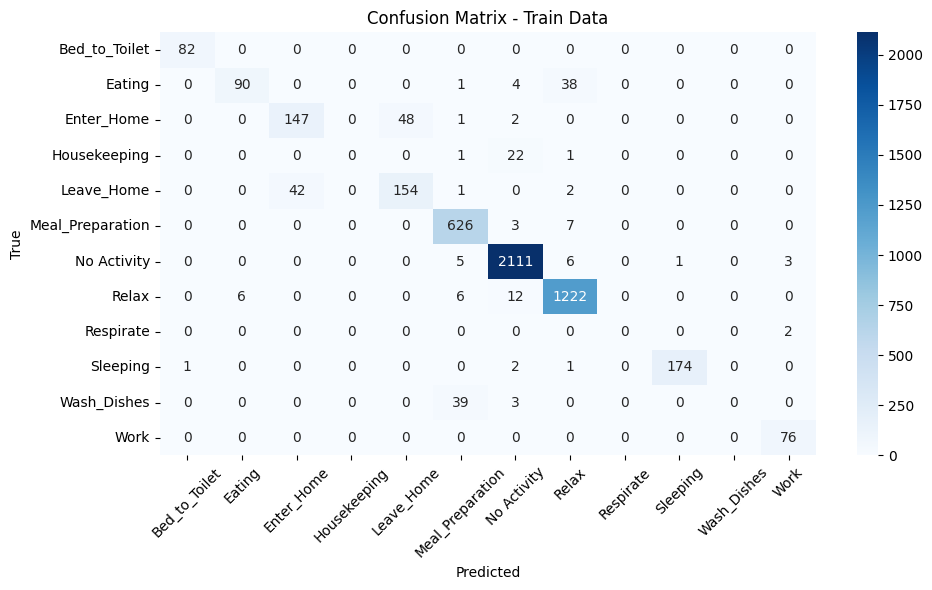


--- Validation Data ---
Accuracy : 95.04%
Precision: 95.17%
Recall   : 95.04%
F1 Score : 94.53%


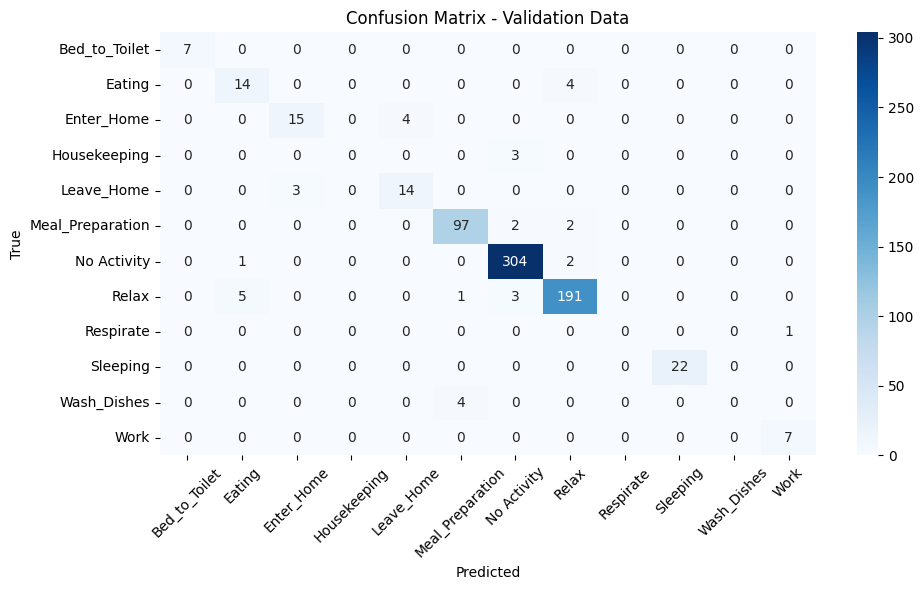


--- Test Data ---
Accuracy : 95.19%
Precision: 95.23%
Recall   : 95.19%
F1 Score : 94.59%


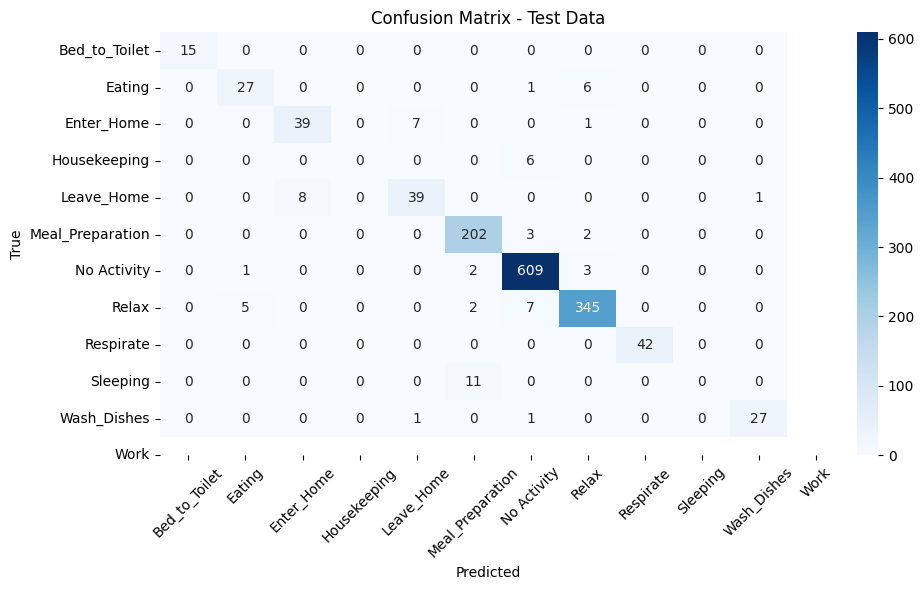

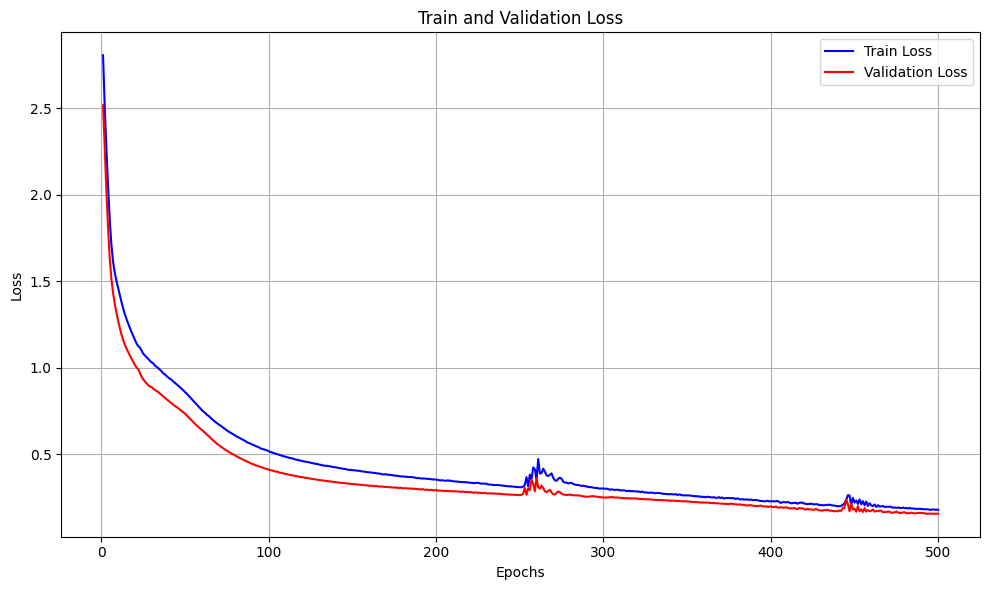

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


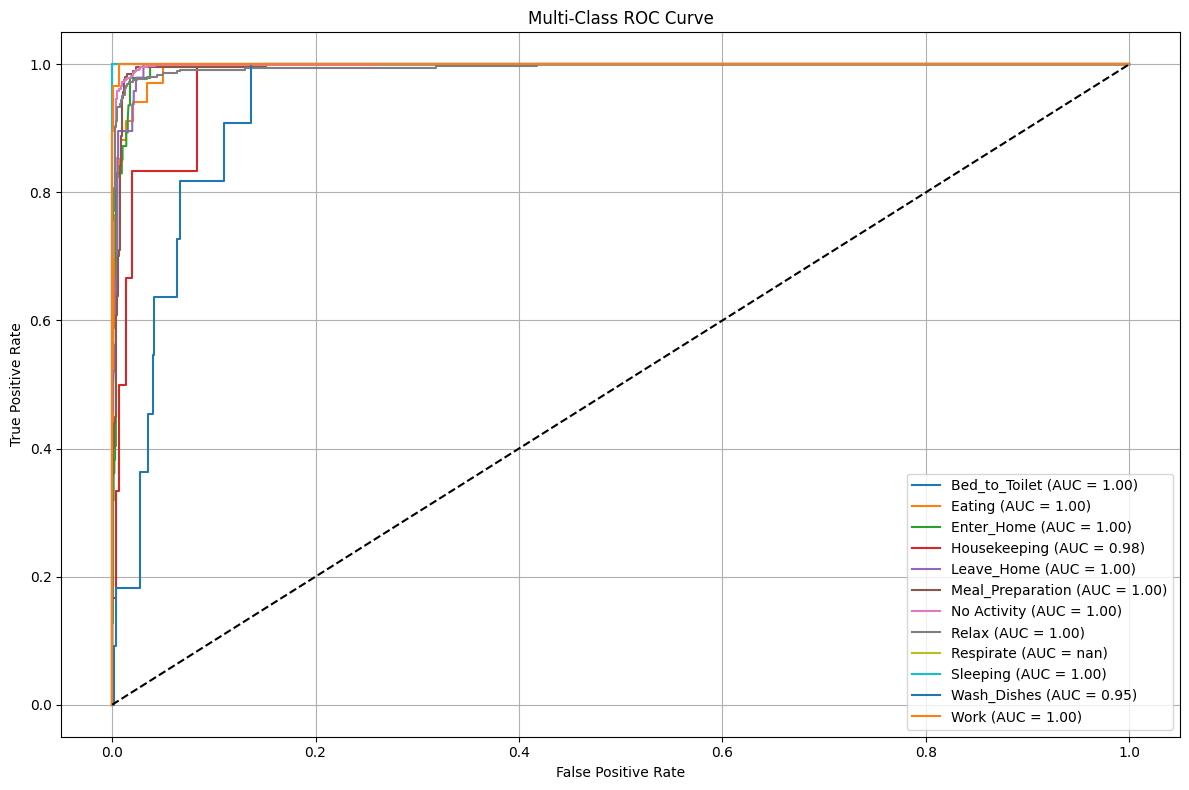

In [10]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

class TransformerGRUParallel(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, gru_hidden_sizes, num_classes, unique_sensor_dim, dropout=0.2):
        super(TransformerGRUParallel, self).__init__()

        self.sensor_embedding = nn.Embedding(num_embeddings=unique_sensor_dim, embedding_dim=ff_dim)
        self.feature_embedding = nn.Linear(d_model - 1, ff_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=ff_dim, num_heads=num_heads, dropout=dropout)

        self.gru1 = nn.GRU(input_size=ff_dim, hidden_size=gru_hidden_sizes[0], batch_first=True, num_layers=2, dropout=dropout, bidirectional=True)
        self.gru2 = nn.GRU(input_size=gru_hidden_sizes[0]*2, hidden_size=gru_hidden_sizes[1], batch_first=True, num_layers=2, dropout=dropout, bidirectional=True)
        self.gru3 = nn.GRU(input_size=gru_hidden_sizes[1]*2, hidden_size=gru_hidden_sizes[2], batch_first=True, num_layers=2, dropout=dropout, bidirectional=True)

        self.fc = nn.Linear(ff_dim + gru_hidden_sizes[2]*2, num_classes)

    def forward(self, x):
        unique_sensor_features = x[:, :, 0].long()
        other_features = x[:, :, 1:]

        unique_embedding = self.sensor_embedding(unique_sensor_features)
        other_embedding = self.feature_embedding(other_features)

        combined_embedding = unique_embedding + other_embedding

        attn_input = combined_embedding.permute(1, 0, 2)
        attn_output, _ = self.multihead_attn(attn_input, attn_input, attn_input)
        attn_output = attn_output.permute(1, 0, 2)

        gru_out, _ = self.gru1(combined_embedding)
        gru_out, _ = self.gru2(gru_out)
        gru_out, _ = self.gru3(gru_out)

        combined = torch.cat((attn_output.mean(dim=1), gru_out.mean(dim=1)), dim=1)

        output = self.fc(combined)
        return output


features_size = X_train_tensor.shape[2]
num_classes = len(np.unique(y))
unique_sensor_dim = len(np.unique(X_train_tensor[:, :, 0].cpu().numpy()))

model = TransformerGRUParallel(
    d_model=features_size,
    num_heads=4,
    ff_dim=256,
    gru_hidden_sizes=[64, 128, 128],
    num_classes=num_classes,
    unique_sensor_dim=unique_sensor_dim,
    dropout=0.1
).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


class_names = label_encoder.classes_
label_to_index = {name: idx for idx, name in enumerate(class_names)}
num_classes = len(class_names)
features_size = X_train_tensor.shape[2]
unique_sensor_dim = len(np.unique(X_train_tensor[:, :, 0].cpu().numpy()))


num_epochs = 500
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor.to(device))
        val_loss = criterion(val_outputs, y_val_tensor.to(device))
        val_losses.append(val_loss.item())
            
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

def report_metrics(true, pred, title):
    print(f"\n--- {title} ---")
    print(f"Accuracy : {accuracy_score(true, pred)*100:.2f}%")
    print(f"Precision: {precision_score(true, pred, average='weighted', zero_division=1)*100:.2f}%")
    print(f"Recall   : {recall_score(true, pred, average='weighted', zero_division=1)*100:.2f}%")
    print(f"F1 Score : {f1_score(true, pred, average='weighted', zero_division=1)*100:.2f}%")
    
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor.to(device)).argmax(dim=1).cpu().numpy()
    val_preds = model(X_val_tensor.to(device)).argmax(dim=1).cpu().numpy()
    test_preds = model(X_test_tensor.to(device)).argmax(dim=1).cpu().numpy()


train_labels = y_train_tensor.cpu().numpy()
val_labels = y_val_tensor.cpu().numpy()
test_labels = y_test_tensor.cpu().numpy()

report_metrics(train_labels, train_preds, "Train Data")
report_metrics(val_labels, val_preds, "Validation Data")
report_metrics(test_labels, test_preds, "Test Data")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    y_probs = torch.softmax(model(X_test_tensor.to(device)), dim=1).cpu().numpy()
    y_true_bin = label_binarize(test_labels, classes=np.arange(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
